---
title: 'Lab01: Portugese Bank Marketing Data'
subtitle: "MSDS 7331"
authors: "Anthony Burton-Cordova, Azadeh Hosseinzadeh?, Will Jones, Nick Sager"
date: September 1, 2023
jupyter: python3
---

## Business Understanding

This dataset is from a direct telemarketing campaign of a Portuguese banking institution collected from 2008 to 2013. The goal of the campaign was to get the customer to subscribe to a term deposit. The dataset contains 41188 records and 21 features. The features are the product of feature selection by the original authors [@Moro2014ADA] and include information about the customer, the marketing campaign, and the bank. The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/222/bank+marketing).

The data was collected to aid the researchers in predicting which clients would subscribe to the term deposit offered by the direct marketing campaign. Presumably, this information would be useful to target future marketing campaigns to clients who are more likely to subscribe to the term deposit. This would help the bank to save on marketing costs and get the product to the clients who need it more. The authors of the original paper were able achieve a ROC or 0.80 using a Neural Network Model using 22 features out of the original 150. It is unclear which features have survived in the UCI version of this dataset, but success for us will be defined as approaching or exceeding the original ROC of 0.80.

While this data is now over ten years old, and specific to a Portuguese bank, it is still relevant to the problem of targeted marketing campaigns. We expect the insights gained from this project will generalize to many other business use cases.

## Data Meaning and Type

The data is broken into four categories: Client data, variables related to the last contact of the current campaign, other attributes, and social and economic context attributes. It is a mix of categorical and numeric data, and differs from the base dataset in that Economic data published by the Bank of Portugal is included and average yearly balance is excluded. The authors of the original paper [@Moro2014ADA] found that adding the Socioeconomic data significantly improved the performance of their models, so we have included it in our analysis. Of note, the 'duration' feature is highly correlated with the target variable, but it would not be known until after a call is made. We will keep it in the dataset for comparison purposes, but will not include it in any predictive models. The following description of the data is adopted from the file 'bank-additional-names.txt' included with the dataset.

Bank Client Data:
- Age: Integer value of the client's age. (age: int64)
- Job: Categorical type of job (job: object) 
  - levels: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown' 
- Marital Status: Categorical marital status (marital: object)
  - levels: "married", "divorced", "single"; note: "divorced" means divorced or widowed
- Education: Client highest level of education (education: object)
  - levels: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown'
- Default: Categorical indicating whether the client has credit in default? (default: binary object)
- Housing Loan: Client has housing loan? (housing: binary object)
- Personal Loan: Client has a personal loan? (loan: binary object)

Variables related to the last contact of the current campaign:
- Method of contact: Contact communication type (contact: object)
  - levels: "cellular", "telephone" 
- Month: last contact month of year (month: object)
  - levels: "jan", "feb", "mar", ..., "nov", "dec"
  - **Convert to Integer?**
  - Would be useful if we had current date to find difference (new feature creation)
- Day of Week : last contact day of the week (day_of_week: object)
  - levels: "mon", "tue", "wed", "thu", "fri"
- Duration of last contact: last contact duration, in seconds (duration: Int64). 
  - Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Other attributes:
- Number of Contacts: number of contacts performed during this campaign and for this client including last contact(campaign: Int64)
- Days Elapsed: number of days that passed by after the client was last contacted from a previous campaign (pdays: Int64)
  - 999 means client was not previously contacted
- Previous Contacts: number of contacts performed before this campaign and for this client (previous: Int64)
- Previous Outcome: outcome of the previous marketing campaign (poutcome: object)
  - levels: "failure","nonexistent","success"
  - **Consider making binary: "success" or "not success"**
  - **Consider making nonexistent NA and handling**

Social and economic context attributes:
- Employment Variation Rate - quarterly indicator (emp.var.rate: float64)
- Consumer Price Index - monthly indicator (cons.price.idx: float64)     
- Consumer Confidence Index - monthly indicator (cons.conf.idx: float64)     
- Euribor 3 month rate - daily indicator (euribor3m: float64)
- Number of Employees - quarterly indicator (nr.employed: float64)

Output variable (desired target):
- Success: Has the client subscribed a term deposit? (y: binary object)

In [1]:
import pandas as pd

# Choose File
RawBank = "https://raw.githubusercontent.com/NickSager/DS7331_Projects/main/Lab01/data/bank-additional-full.csv"
#RawBank = "data/bank-additional-full.csv"

# Read the CSV file with a semicolon ; separator
bank = pd.read_csv(RawBank, sep=';')

# Get info on the dataset
print(bank.info())
bank.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


## Data Quality

NA values are coded as 'unknown', 'nonexistent', or 999 in the dataset. We will need to convert these to NA in order to determine how many are missing and how to handle them.

In [2]:
import numpy as np

# let's set those values to NaN, so that Pandas understand they are missing
df = bank.copy() # make a copy of the dataframe
df = df.replace(to_replace = 'unknown', value = np.nan) # replace unknown with NaN (not a number)
df = df.replace(to_replace = 999, value = np.nan) # replace 999 with NaN (not a number)
df = df.replace(to_replace = 'nonexistent', value = np.nan) # replace nonexistent with NaN (not a number)

print (df.info())
df.describe() # scroll over to see the values

# From course material "01. Pandas.ibynb"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41186 non-null  float64
 11  campaign        41188 non-null  int64  
 12  pdays           1515 non-null   float64
 13  previous        41188 non-null  int64  
 14  poutcome        5625 non-null   object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41186.000000,41188.000000,1515.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.249041,2.567593,6.014521,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.234158,2.770014,3.824906,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,3.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,6.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,7.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


With the exception of Days Elapsed and two missing values in Duration, the numerical data is complete. We will change the two entries with 999s duration back to 999s in case they don't represent an entry error. Based on the maximum duration, that value isn't necessarily an outlier. The amount of non-null Days Elapsed values is actually very small (3.7% of total records). This means that the vast majority of cases represent the first call of the current marketing campaign.

Of the categorical values, Previous Outcome, Job, Marital Status, Education, and Default have missing values. There are also roughly 1000 records which have missing values for both housing and personal loan. Previous outcome has the most missing values (13.7% non-null), which is in agreement with our assumption that most of the records represent the first call of the current marketing campaign. 

One can imagine that some clients could have jobs that don't fit into the categories provided. Rather than exclude these records, we will change the NA's back to 'unknown' and treat this as it's own category. We will do the same for Marital Status and Education. For default, housing, and personal loan, we will assume that the missing values indicate that the client does not have a loan or credit in default. We will change the NA's to 'no' for these features, assuming that the presence of any of these is easier to find than the absence.

Previous outcome is a little more difficult to handle. One option would be to change it to a binary variable indicating "success" or "not success". However, success in a previous marketing campaign probably does provide important information about the client. We will change the NA's to "not contacted" and treat it as it's own category. This category will be largely ignored in the analysis, but will be included in predictive models to avoid losing information. NA's in the days elapsed feature will be changed to the mean value of the non-null records.

In [3]:
# Change NA Categoricals to 'unknown'
df['job'] = df['job'].fillna('unknown')
df['marital'] = df['marital'].fillna('unknown')
df['education'] = df['education'].fillna('unknown')

# Change NA Credit history values to 'no'
df['default'] = df['default'].fillna('no')
df['housing'] = df['housing'].fillna('no')
df['loan'] = df['loan'].fillna('no')

# Change NA Previous Outcome to 'not contacted'
df['poutcome'] = df['poutcome'].fillna('not contacted')

# Change NA pdays to the mean
df['pdays'] = df['pdays'].fillna(df['pdays'].mean())

# Change NA Duration to '999'
df['duration'] = df['duration'].fillna(999)

print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  float64
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  float64
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,6.014521,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,0.733337,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,6.014521,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,6.014521,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,6.014521,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


There are now 41188 records in the dataset without missing values. The summary statistics appear similar with the exception of days elapsed. We will consider removing this feature later on, as 96% of it represents an imputed value.

## Simple Statistics


In [4]:
#Stats on the data
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,6.014521,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,0.733337,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,6.014521,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,6.014521,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,6.014521,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,27.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


The table above shows summary statistics for the numerical features in the dataset. Most clients are between 20 and 60 years old, and have been contacted 2.5 times during the campaign. Most clients have not been contacted in previous campaigns. The economic features show the range of values during this study, and can be used to gauge the strength of the Portuguese economy at the time of contact. Although duration will not be used for prediction, the mean duration is 258 seconds, or about 4.3 minutes. Interestingly, the standard deviation is 259 seconds, which suggests that a large proportion of clients either didn't answer or hung up very quickly.

In [5]:
# Calculate the percentage of people who subscribed to a term deposit
len(df[df.y == 'yes']) / len(df) * 100.0

11.265417111780131

Of the clients targeted by this campaign, 11.3% subscribed to the term deposit.

In [6]:
df.groupby(by='y').median(numeric_only = True)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,
no,38.0,163.5,2.0,6.014521,0.0,1.1,93.918,-41.8,4.857,5195.8
yes,37.0,449.0,2.0,6.014521,0.0,-1.8,93.200,-40.4,1.266,5099.1


We can see a few differences between the clients who subscribed to the term deposit and those who did not by looking at the median of the numeric variables. The median age of those who subscribed is slightly lower than those who did not. The median duration of phone call was much higher for those who subscribed, although we will exclude this feature in predictive models.

The socioeconomic variables all show differences between the groups, suggesting that economic conditions may be a factor in a client's decision whether to subscribe or not. More analysis is necessary to test whether these differences are significant, but we expect these variables to be important predictors.

In [7]:
# Create a numeric version of the y variable where yes = 1 and no = 0
df['y_num'] = df['y'].map({'yes': 1, 'no': 0})

# Lets aggregate by job and count subscription rates
df_grouped = df.groupby(by='job')
print ('---------------------------------------')
print('Count by Job:')
print (df_grouped.y_num.count())
print ('---------------------------------------')
print('Subscription Rate by Job:')
print (df_grouped.y_num.sum() / df_grouped.y_num.count())

# Adapted from Course material "02. Data Visualization.ipynb"

---------------------------------------
Count by Job:
job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
Name: y_num, dtype: int64
---------------------------------------
Subscription Rate by Job:
job
admin.           0.129726
blue-collar      0.068943
entrepreneur     0.085165
housemaid        0.100000
management       0.112175
retired          0.252326
self-employed    0.104856
services         0.081381
student          0.314286
technician       0.108260
unemployed       0.142012
unknown          0.112121
Name: y_num, dtype: float64


The plurality of jobs are of type 'Admin.' and 'Blue-Collar'. We can see that there are large variations in average subscription rates by job type. Retired people and Students appear much more likely to subscribe, while blue-collar workers are appear less likely.

In [8]:
# let's break up the age variable
df['age_range'] = pd.cut(df.age,[0,40,60,1e6],3,labels=['Young','Middle-Age','Old']) # this creates a new variable
df.age_range.describe()

count     41188
unique        3
top       Young
freq      23768
Name: age_range, dtype: object

In [9]:
# now lets group with the new variable
df_grouped = df.groupby(by=['age_range'])
print ("Percentage of subscribers in each group:")
print (df_grouped.y_num.sum() / df_grouped.y_num.count() *100)

Percentage of subscribers in each group:
age_range
Young         11.448166
Middle-Age     9.115687
Old           45.494505
Name: y_num, dtype: float64


Based on the grouping, it appears that Middle-aged people are the least likely to subscribe and old people are the most likely by a large margin. This suggests that age is a significant factor in whether a client subscribes to the term deposit.

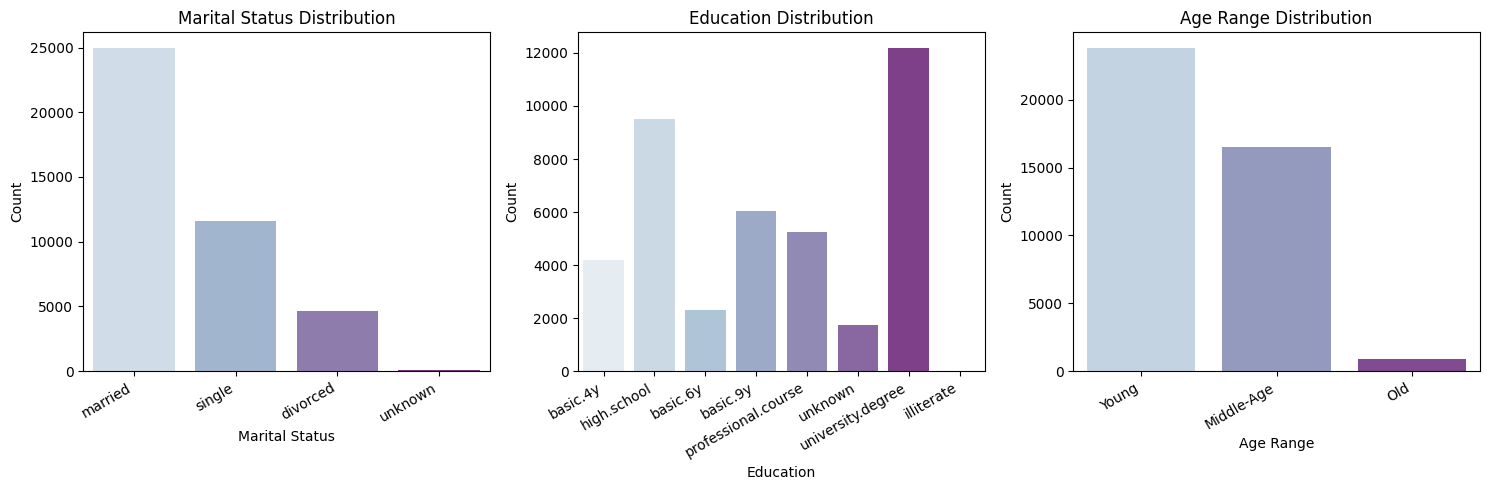

In [10]:
# Visualize proportions of marital status, education, and age range
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(15, 5))

# Graph Matital Status
sns.countplot(x="marital", data=df, palette="BuPu", ax=axes[0])
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Count')
axes[0].set_title('Marital Status Distribution')

# Graph Education Distribution
sns.countplot(x="education", data=df, palette="BuPu", ax=axes[1])
axes[1].set_xlabel('Education')
axes[1].set_ylabel('Count')
axes[1].set_title('Education Distribution')

# Graph Age Range Distribution
sns.countplot(x="age_range", data=df, palette="BuPu", ax=axes[2])
axes[2].set_xlabel('Age Range')
axes[2].set_ylabel('Count')
axes[2].set_title('Age Range Distribution')

plt.setp(axes[0].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axes[1].get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(axes[2].get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()  # Adjust layout so labels do not overlap
plt.show()

The majority of clients are married, with an slightly smaller portion being single or divorced. Most clients have a university degree or high school diploma. There are very few with unknown or illiterate education status, and a fair number with basic education. The largest age group is Young Adults (17-40), followed by Middle-Age (40-60). There are very few clients over 60, although as previously discussed, this group has very high subscription rates and is expected to be a strong predictor.

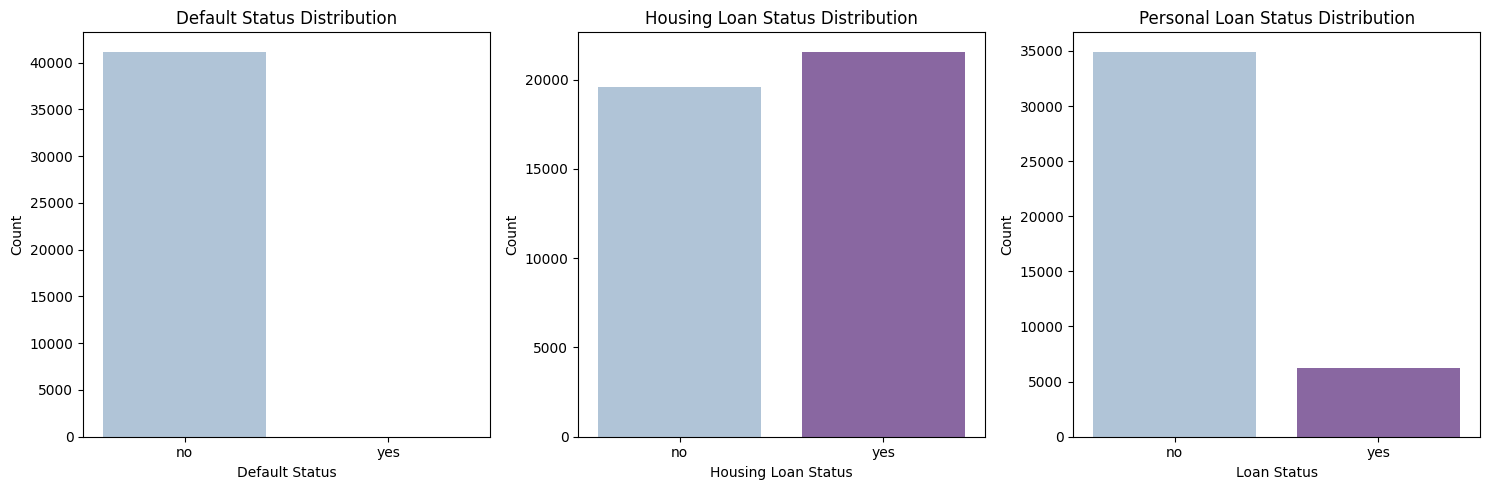

In [11]:
# Visualize proportions of loan status
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
f, axes = plt.subplots(1, 3, figsize=(15, 5))

# Graph Default Distribution
sns.countplot(x="default", data=df, palette="BuPu", ax=axes[0])
axes[0].set_xlabel('Default Status')
axes[0].set_ylabel('Count')
axes[0].set_title('Default Status Distribution')


# Graph Housing Loan Distribution
sns.countplot(x="housing", data=df, palette="BuPu", ax=axes[1])
axes[1].set_xlabel('Housing Loan Status')
axes[1].set_ylabel('Count')
axes[1].set_title('Housing Loan Status Distribution')

# Graph Personal Loan Distribution
sns.countplot(x="loan", data=df, palette="BuPu", ax=axes[2])
axes[2].set_xlabel('Loan Status')
axes[2].set_ylabel('Count')
axes[2].set_title('Personal Loan Status Distribution')

plt.tight_layout()  # Adjust layout so labels do not overlap
plt.show()

Exploring loan and credit status, we can see that almost none of the clients have credit in default. Housing loans are approximately equally distributed, with slightly more clients having a mortgage. There is a small but significant proportion of clients which have a personal loan.

## Visualize Attributes

Visualize the most interesting attributes (at least 5 attributes, your opinion on what is interesting). Important: Interpret the implications for each visualization. Explain for each attribute why the chosen visualization is appropriate.

Most of the visualization attributes in simple statistics are reused for this section due to their interesting aspects. Making these visuals will help lead us to further analysis and give us insights of our client make up. Using these plots can help lead us to how we will sample in the future and make statistical inferences. 

Text(0.5, 1.0, 'Makeup of Marital Status')

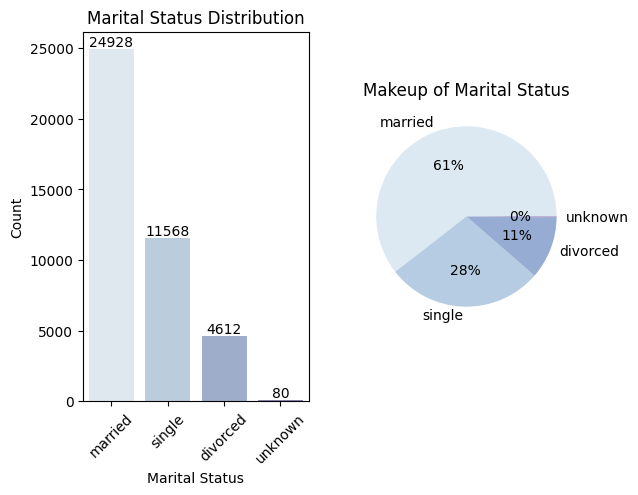

In [12]:
f, axes = plt.subplots(1, 2)

# define Seaborn color palette to use
palette_color = sns.color_palette("BuPu")

#bar chart
sns.countplot(x="marital", data=df, palette=palette_color, ax=axes[0])
axes[0].set_xlabel('Marital Status')
axes[0].set_ylabel('Count')
axes[0].set_title('Marital Status Distribution')
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].bar_label(axes[0].containers[0])
#pie chart 
plt.pie(df['marital'].value_counts(), labels=df['marital'].unique(),colors=palette_color, autopct='%.0f%%')
axes[1].set_title('Makeup of Marital Status')

Majority of the clients are married (61%) with single clients making up most of the rest of the percentage (28%). This vizualization of both pie chart and count plot are necessary to show the martial status distribution of the clients. With this visualization we can see that its weighted heavly to married clients which we will keep in mind for future inferences. 

Text(0.5, 1.0, 'Makeup of Education Level')

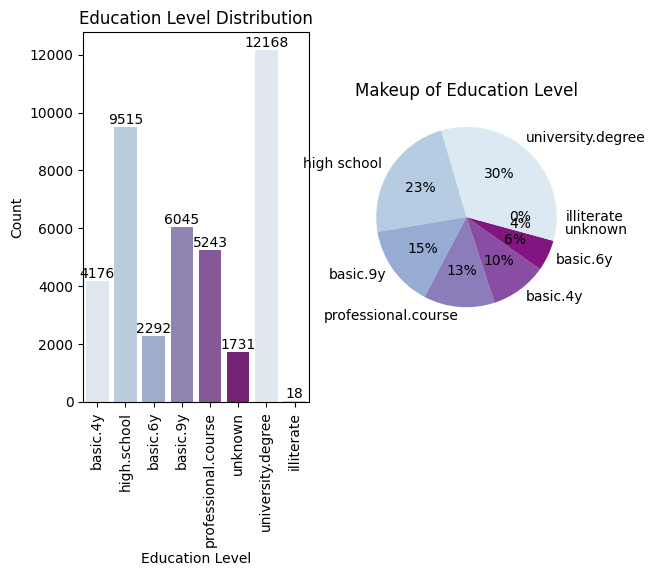

In [13]:
f, axes = plt.subplots(1, 2)

# define Seaborn color palette to use
palette_color = sns.color_palette("BuPu")

#bar chart
sns.countplot(x="education", data=df, palette=palette_color, ax=axes[0])
axes[0].set_xlabel('Education Level')
axes[0].set_ylabel('Count')
axes[0].set_title('Education Level Distribution')
axes[0].tick_params(axis='x', labelrotation=90)
axes[0].bar_label(axes[0].containers[0])
#pie chart 
plt.pie(df['education'].value_counts(), labels=['university.degree', 'high school', 'basic.9y', 'professional.course', 'basic.4y', 'basic.6y', 'unknown', 'illiterate'],colors=palette_color, autopct='%.0f%%')
axes[1].set_title('Makeup of Education Level')


This visualization of the education distribution shows how well educated our clients are. Most of the clients have completed high school or hold some form of a higher educational certificate. There is a large number of clients that dropped out in high school(13%). This could leave most of our inferences to population of more highly educated people and affect how we sample data for our models. 

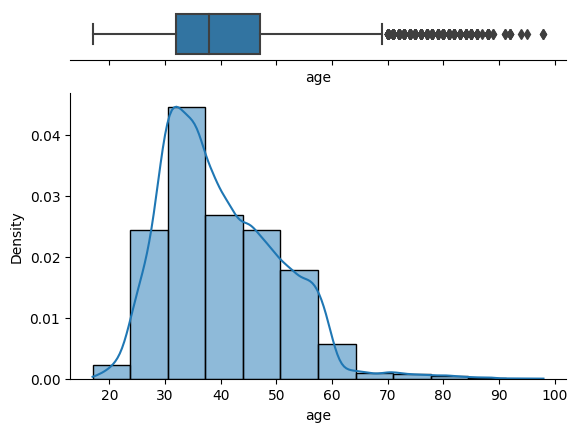

In [14]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=df.age, ax=ax_box)
sns.histplot(x=df.age, bins=12, kde=True, stat='density', ax=ax_hist)

ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

Choosing this visualizations lets us see how the age distribution of the clients is represented in the dataset. While clients are represented from ages of ~20 to ~100 there is a mean of about 37 and 50% of the clients are below the age of 35. So most of our inferences and sampling will be pulled to young and middle age adults. There are some outliers in the data which will possibly make the attribute logged in future models or the outliers elimated from the model. 

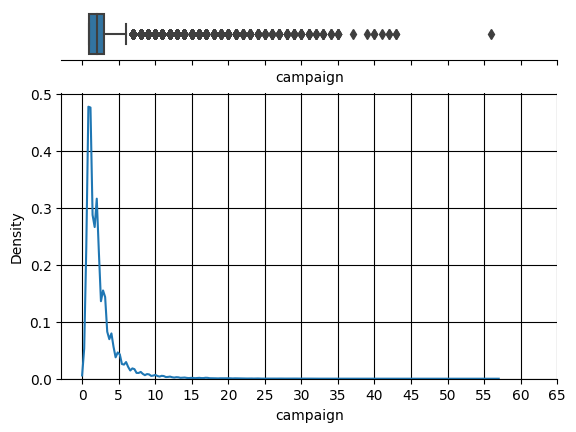

In [15]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(x=df.campaign, ax=ax_box)
sns.kdeplot(x=df.campaign,ax=ax_hist)
ax_hist.set_xticks(range(0,70,5))
ax_hist.grid(which='major', color='black')
ax_box.set(yticks=[])
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

This visualization of both kde and boxplot are to show the number of contacts during the campaign which as we can see ~75% of the number of contacts to each client are under 5 contacts. However there are some that have been contacted are larger number of times with the maximum being 55. This gives us a good idea for further analysis to see which of these had success having the client subscribe to a term deposit. Like the previous visualization going forward into modeling the attribute will need to be logged and might have a larger impact on the modeling with the outliers. 

Text(0.5, 1.0, 'Makeup of Contact Method')

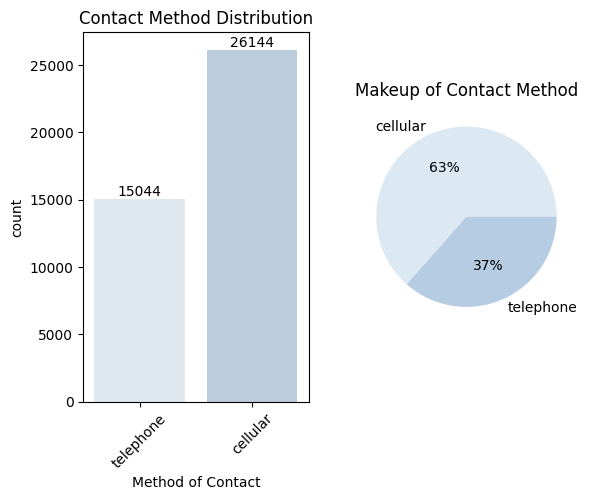

In [16]:
f, axes = plt.subplots(1, 2)

# define Seaborn color palette to use
palette_color = sns.color_palette("BuPu")

#bar chart
sns.countplot(x="contact", data=df, palette=palette_color, ax=axes[0])
axes[0].set_ylabel('count')
axes[0].set_xlabel('Method of Contact')
axes[0].set_title('Contact Method Distribution')
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].bar_label(axes[0].containers[0])
#pie chart 
plt.pie(df['contact'].value_counts(), labels=['cellular', 'telephone'],colors=palette_color, autopct='%.0f%%')
axes[1].set_title('Makeup of Contact Method')

This gives us a good idea of the contact methods used and the makeup of them. Most of the clients were contacted by celluar (63%). Like the inferences to others we will need further analysis to see the percentage of each that worked in subscribing to term deposits but some oversampling might me needed to have a even chance of inferences to general population.

Text(0.5, 1.0, 'Makeup of Job')

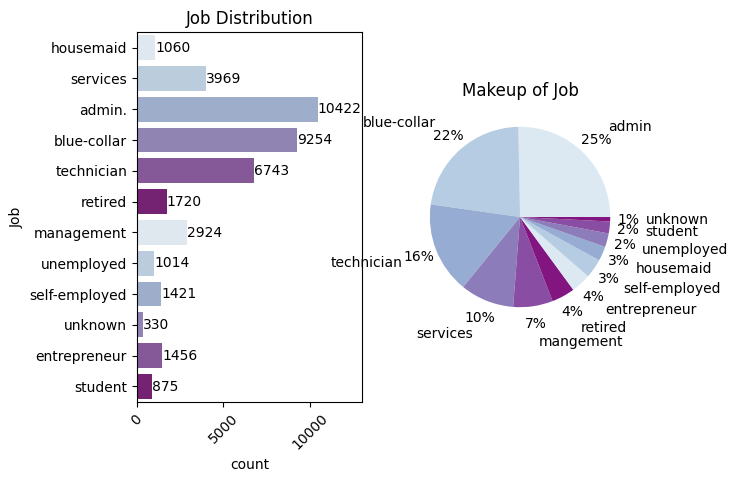

In [17]:
f, axes = plt.subplots(1, 2)

# define Seaborn color palette to use
palette_color = sns.color_palette("BuPu")

#bar chart
sns.countplot(y="job", data=df, palette=palette_color, ax=axes[0])
axes[0].set_xlabel('count')
axes[0].set_xlim(0, 13000)
axes[0].set_ylabel('Job')
axes[0].set_title('Job Distribution')
axes[0].tick_params(axis='x', labelrotation=45)
axes[0].bar_label(axes[0].containers[0])
#pie chart 
plt.pie(df['job'].value_counts(), labels=['admin', 'blue-collar', 'technician', 'services', 'mangement','retired', 'entrepreneur', 'self-employed', 'housemaid', 'unemployed', 'student', 'unknown'],colors=palette_color, autopct='%.0f%%', pctdistance=1.2, labeldistance=1.4)
axes[1].set_title('Makeup of Job')

We need to see what type of workforce jobs are held by are clients, with some jobs higher paying than others it will give an idea of the population the bank serves. the count and pie chart will show a great idea of the percentage and count of the job feilds. A large majority of the clients are admin/blue-collar/technican which can sway our statistical inferences to these feilds.

## Explore Joint Attributes

Visualize relationships between attributes: Look at the attributes via scatter plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain any interesting relationships.

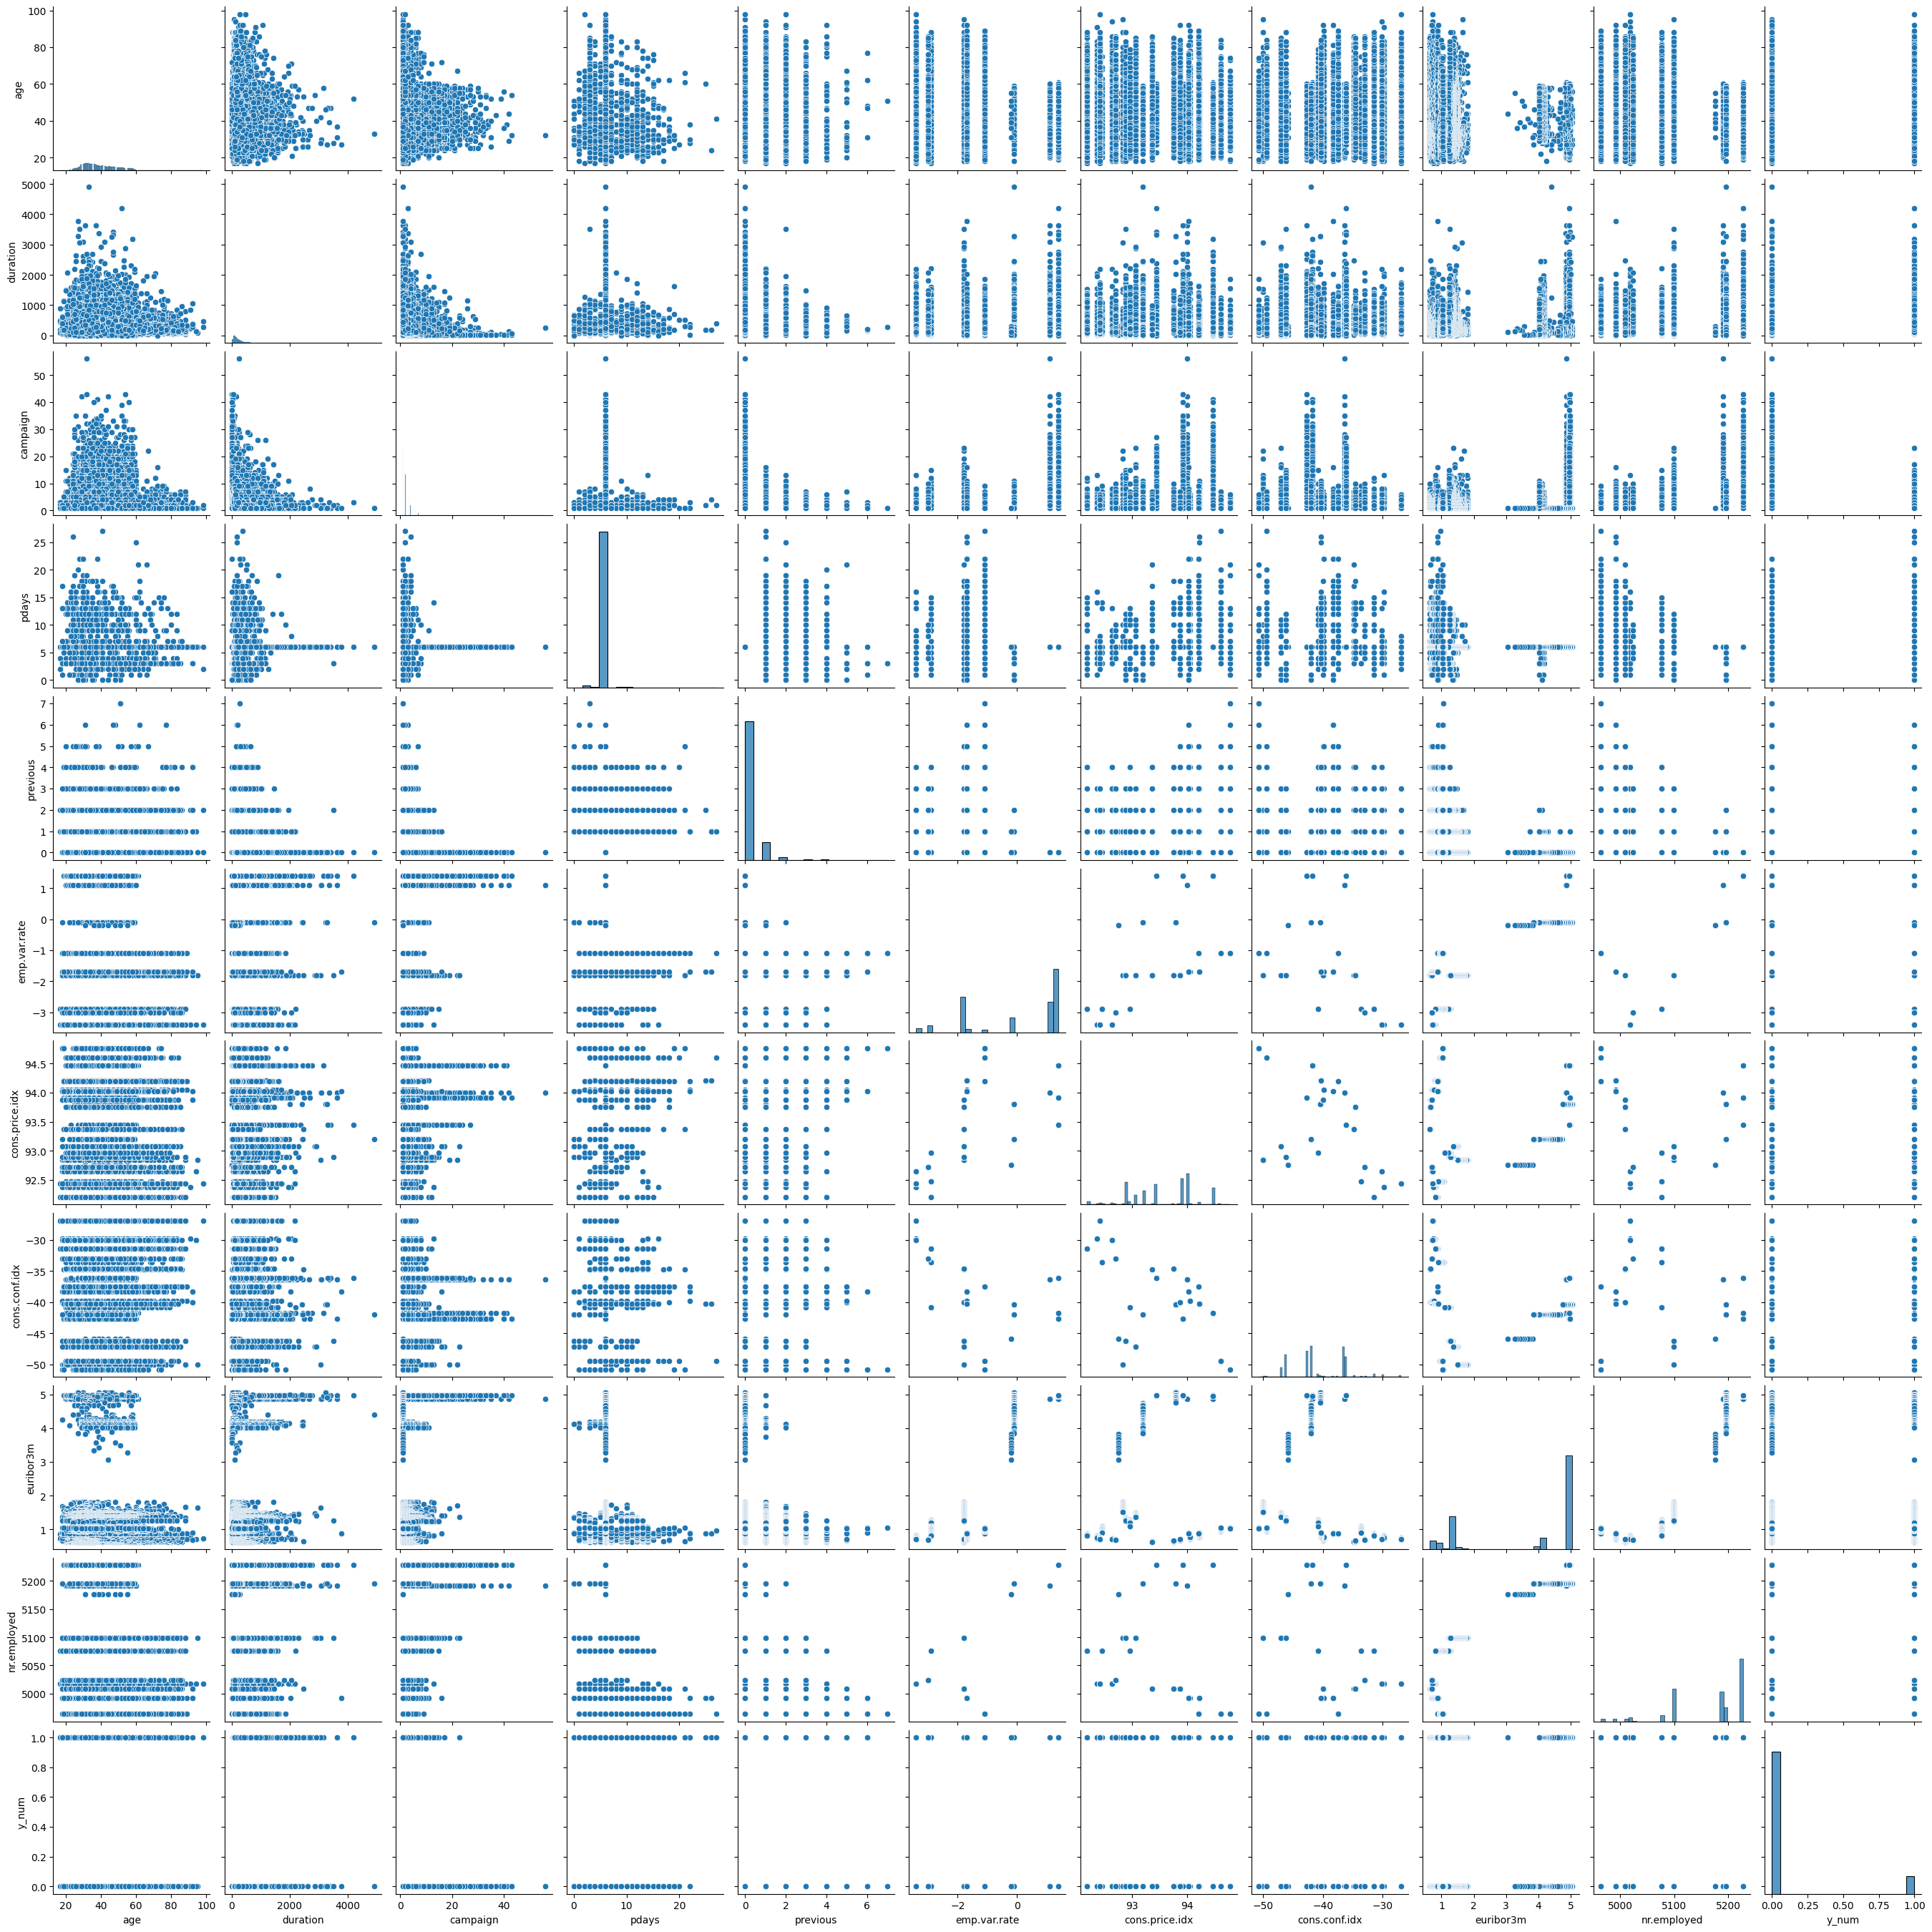

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

#Scatter Plots

# Select numeric columns from dataframe
numeric_columns = df.select_dtypes(include=['number'])

# Create a scatter plot matrix
sns.pairplot(numeric_columns)
plt.show()

There were a few approches we took to visualize and explore the relationships between attributes. We chose to look at Scatter plots, a correlation matrix, and cross-tabulation. The Correlation matrix and the scatter plots help us to identify linearity / collinearity. The cross-tabluation is more of a visual inspection of relationships of categorical variables. Upon looking at the scatter plots and correlation matrix, I was able to identify 6 pairs of potentially intersting interactions. 

Con price ind  Vs. EMP Var Rate - High correlation coefficient, the relationship is weak, and there are signs of collinearity
Euribor3m Vs. Emp Var Rate - High correlation coefficient, the relationship is non-linear, not suggestive of collinearity
Nr.Employed vs. Emp Var Rate - High correlation coefficient, the relationship is weak, linear, suggestive of collinearity
Euripor3m Vs. Cons Price Ind - High correlation coefficient, the relationship is weak, linear, suggestive of collinearity
Nr.Employed Vs Cons proce Ind. - High correlation coefficient, weak relationship, non-linear, not suggestive of collineaity.
Y_Num Vs. Cons Price Index - High correlation coefficient, non-linear relationship, not suggestive of collinearity but strange interaction
Nr.Employed Vs. Euribo3m - High correlation coefficient, Linear realtionship, stronger relaitonship and suggestive of collinearity

All 6 of these intersting relatioships had some form of warning signs worth investigating.

/var/folders/nl/nfxdyzvn0cncv2rk5jtff43h0000gn/T/ipykernel_83843/2077288321.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


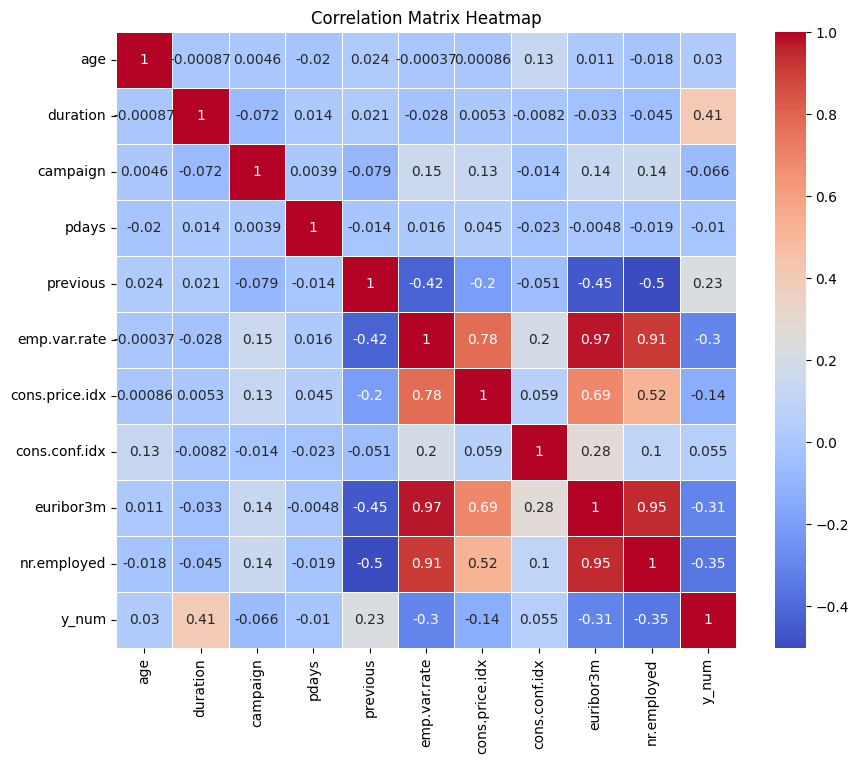

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation Matrix

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [20]:
# Cross-Tabulation

# Get a list of categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Perform cross-tabulation for all combinations of categorical attributes
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 != col2:
            cross_tab = pd.crosstab(df[col1], df[col2])
            print(f"Cross-tabulation between {col1} and {col2}:")
            print(cross_tab)
            print("\n")

Cross-tabulation between job and marital:
marital        divorced  married  single  unknown
job                                              
admin.             1280     5253    3875       14
blue-collar         728     6687    1825       14
entrepreneur        179     1071     203        3
housemaid           161      777     119        3
management          331     2089     501        3
retired             348     1274      93        5
self-employed       133      904     379        5
services            532     2294    1137        6
student               9       41     824        1
technician          774     3670    2287       12
unemployed          124      634     251        5
unknown              13      234      74        9


Cross-tabulation between job and education:
education      basic.4y  basic.6y  basic.9y  high.school  illiterate  \
job                                                                    
admin.               77       151       499         3329           1

Cross-tabulation between default and loan:
loan        no   yes
default             
no       34937  6248
yes          3     0


Cross-tabulation between default and contact:
contact  cellular  telephone
default                     
no          26141      15044
yes             3          0


Cross-tabulation between default and month:
month     apr   aug  dec   jul   jun  mar    may   nov  oct  sep
default                                                         
no       2632  6176  182  7174  5318  546  13769  4100  718  570
yes         0     2    0     0     0    0      0     1    0    0


Cross-tabulation between default and day_of_week:
day_of_week   fri   mon   thu   tue   wed
default                                  
no           7827  8514  8623  8087  8134
yes             0     0     0     3     0


Cross-tabulation between default and poutcome:
poutcome  failure  not contacted  success
default                                  
no           4251          35561     1373
yes     

Cross-tabulation between contact and y:
y             no   yes
contact               
cellular   22291  3853
telephone  14257   787


Cross-tabulation between month and job:
job    admin.  blue-collar  entrepreneur  housemaid  management  retired  \
month                                                                      
apr       644          565           109         47         195      160   
aug      2039          582            74        208         357      342   
dec        50           12             1         10          12       33   
jul      1815         1789           273        239         399      271   
jun      1238         1385           217        136         352      173   
mar       169           50             2          6          42       64   
may      3019         4199           484        296         909      329   
nov      1085          602           269         87         561      136   
oct       197           51            15         19          51   

Cross-tabulation between y and loan:
loan     no   yes
y                
no    30983  5565
yes    3957   683


Cross-tabulation between y and contact:
contact  cellular  telephone
y                           
no          22291      14257
yes          3853        787


Cross-tabulation between y and month:
month   apr   aug  dec   jul   jun  mar    may   nov  oct  sep
y                                                             
no     2093  5523   93  6525  4759  270  12883  3685  403  314
yes     539   655   89   649   559  276    886   416  315  256


Cross-tabulation between y and day_of_week:
day_of_week   fri   mon   thu   tue   wed
y                                        
no           6981  7667  7578  7137  7185
yes           846   847  1045   953   949


Cross-tabulation between y and poutcome:
poutcome  failure  not contacted  success
y                                        
no           3647          32422      479
yes           605           3141      894




## Explore Attributes and Class

Identify and explain interesting relationships between features and the class you are trying to predict (i.e., relationships with variables and the target classification).

## New Features

Are there other features that could be added to the data or created from existing features? Which ones?

## Exceptional Work

In order to narrow down the number of features used for prediction, we will use Principal Component Analysis (PCA) to capture most of the variability. Additionally, the makeup of the most important principal components will provide insight into which features are most important for prediction.

The code in this section is adopted from the course material in the notebook '03. Dimension Reduction.ipynb'.

In [21]:
# Convert all features to numeric using dummy variables
df_numeric = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age_range'], drop_first=True)

df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 54 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   duration                       41188 non-null  float64
 2   campaign                       41188 non-null  int64  
 3   pdays                          41188 non-null  float64
 4   previous                       41188 non-null  int64  
 5   emp.var.rate                   41188 non-null  float64
 6   cons.price.idx                 41188 non-null  float64
 7   cons.conf.idx                  41188 non-null  float64
 8   euribor3m                      41188 non-null  float64
 9   nr.employed                    41188 non-null  float64
 10  y                              41188 non-null  object 
 11  y_num                          41188 non-null  int64  
 12  job_blue-collar                41188 non-null 

PCA requires all features to be numeric, so we have converted the categorical features to dummy variables. This will also be useful to have for certain predictive models.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Separate target and features
X = df_numeric.drop(columns=['y', 'y_num']).values  # Dropping the target column and converting to numpy array
y = df_numeric['y_num'].values

pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X) # fit data and then transform it

lda = LDA(n_components=1)
X_lda = lda.fit(X, y).transform(X) # fit data and then transform it

# print the components

print ('pca:', pca.components_)
print ('lda:', lda.scalings_.T)

In [ ]:
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X)

explained_var = pca.explained_variance_ratio_
cum_explained_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.bar(range(len(explained_var)), explained_var, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(len(cum_explained_var)), cum_explained_var, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see that the first principal component explains almost all of the variance. Looking at the coefficients, we can see that 'Duration' is the most important factor by almost two orders of magnitude. As discussed earlier, this isn't really a valid predictor but it is interesting to see just how much it is correlated with subscriptions.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract weights (loadings) for the first principal component
loadings = pca.components_[0]

# Create a DataFrame for the loadings
feature_names = df_numeric.drop(columns=['y', 'y_num']).columns.tolist()
df_loadings = pd.DataFrame({'feature': feature_names, 'loading': loadings})

# Sort DataFrame by the absolute value of the loading for better visualization
df_loadings['abs_loading'] = df_loadings['loading'].abs()
df_loadings = df_loadings.sort_values(by='abs_loading', ascending=False)

# Create a bar plot with a taller figure
plt.figure(figsize=(10,12))  # Increase the height
ax = sns.barplot(x='abs_loading', y='feature', data=df_loadings)
ax.set_xscale('log')  # Set the x-axis to a logarithmic scale
plt.title('Feature Importance for First Principal Component (Absolute Values on Log Scale)')
plt.xlabel('Absolute Loading (Log Scale)')
plt.ylabel('Feature')
plt.show()

# Extensive help with debugging: GPT-4

The feature loadings of the first principal component are shown on the figure above. They are plotted as absolute values, so they can be regarded as feature importance. The scale is logarithmic, so the difference in feature importance is much larger than it appears. We can see that 'Duration' is by far the most important feature, followed by 'Employment Number (Portugal)' and 'Campaign'. The economic features are all fairly highly ranked, which suggests they are an important predictor of subscription to a term deposit.

## Conclusion

## References

@article{Moro2014ADA,
  title={A data-driven approach to predict the success of bank telemarketing},
  author={S{\'e}rgio Moro and P. Cortez and Paulo Rita},
  journal={Decis. Support Syst.},
  year={2014},
  volume={62},
  pages={22-31},
  url={https://api.semanticscholar.org/CorpusID:14181100}
}